In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer
import networkx as nx
import scipy.sparse as sp

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
from core.SimpleNet import SimpleNet
from core.OldGraphConvNet import OldGraphConvNet
from core.GraphConvNet import GraphConvNet
from core.EmbeddingDataSet import EmbeddingDataSet
from core.GraphDataBlock import GraphDataBlock
from util.plot_graph_embedding import plot_graph_embedding
from util.evaluation_metrics import graph_trustworthiness, trustworthiness
from util.network_utils import get_net_projection
from util.graph_utils import get_shortest_path_matrix, neighbor_sampling

In [4]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [5]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'cuda'
else:
    print('cuda not available')
    device = 'cpu'

cuda not available


In [9]:
dataset_name = 'pubmed_full'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)
dataset.summarise()

Time to create all data (s) = 0.0911
Name of dataset = pubmed_full
Input dimension = 500
Number of training samples = 19717
Training labels = True


In [10]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 2 # number of hidden layers

In [13]:
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)

Time to create all data (s) = 0.0665


In [10]:
# y_pred_1 = get_net_projection(dataset.all_data, net_1)

In [95]:
n_plot = 50
D_layers = [9, 14]
mask = np.random.choice(dataset.all_indices, size=n_plot, replace=False)
mask = neighbor_sampling(dataset.adj_matrix, mask, D_layers)
inputs = dataset.inputs[mask]
labels = dataset.labels[mask]
W = dataset.adj_matrix[mask, :][:, mask]
print(len(mask))
G = GraphDataBlock(inputs, labels, W)

1319


In [108]:
# Graph net
net_parameters['H'] = 128 # number of hidden units

net_1 = GraphConvNet(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/pubmed_full_6/'
filename = root + 'graph_net_3.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])

In [109]:
y_emb_1 = get_net_projection([G], net_1)
plot_graph_embedding(y_emb_1, labels, W, line_alpha=0.1)

In [98]:
# Graph net
net_parameters['H'] = 128 # number of hidden units

net_1 = GraphConvNet(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/pubmed_full_7/'
filename = root + 'graph_net_3.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])

In [99]:
y_emb_2 = get_net_projection([G], net_1)
plot_graph_embedding(y_emb_2, labels, W, line_alpha=0.1)

In [100]:
# Graph net
net_parameters['H'] = 128 # number of hidden units

net_1 = GraphConvNet(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/pubmed_full_8/'
filename = root + 'graph_net_3.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])

In [101]:
y_emb_3 = get_net_projection([G], net_1)
plot_graph_embedding(y_emb_3, labels, W, line_alpha=0.1)

In [102]:
def combined_metric(y_emb, feature_matrix, W, k=5):
    from sklearn.neighbors import kneighbors_graph
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    z_emb = scaler.fit_transform(y_emb)
    z_dist_matrix = pairwise_distances(z_emb, squared=True)
    
    #feature_dist_matrix = pairwise_distances(feature_matrix, metric='cosine')
    knn_graph = kneighbors_graph(feature_matrix, n_neighbors=k, mode='connectivity', metric='cosine', include_self=False)
    
    loss_1 = np.sum(W.toarray() * z_dist_matrix) / W.getnnz()
    loss_2 = np.sum(knn_graph.toarray() * z_dist_matrix) / knn_graph.getnnz()
    loss = loss_1 + loss_2
    
    print('Graph distances: ', loss_1)
    print('Feature distances: ', loss_2)
    print('Total loss: ', loss)
    
    return loss

In [103]:
_ = combined_metric(y_emb_1, inputs, W, k=5)

Graph distances:  0.22225004967822562
Feature distances:  0.5709412738115267
Total loss:  0.7931913234897523


In [104]:
_ = combined_metric(y_emb_2, inputs, W, k=5)

Graph distances:  0.10673217686013232
Feature distances:  0.825824579506141
Total loss:  0.9325567563662733


In [105]:
_ = combined_metric(y_emb_3, inputs, W, k=5)

Graph distances:  0.6426431578513924
Feature distances:  0.31858942793954764
Total loss:  0.9612325857909401


## Archive

In [110]:
assert 1==2

AssertionError: 

In [14]:
# Simple net
net_2 = SimpleNet(net_parameters)
if torch.cuda.is_available(): net_2.cuda()
root = 'results/pubmed_4/'
filename = root + 'simple_net_5.pkl'
checkpoint = torch.load(filename, map_location=device)
net_2.load_state_dict(checkpoint['state_dict'])

In [15]:
y_pred_2 = get_net_projection(dataset.all_data, net_2)

In [17]:
y_emb_2 = get_net_projection([G], net_2)
plot_graph_embedding(y_emb_2, labels, W, line_alpha=0.1)

In [18]:
path_matrix = get_shortest_path_matrix(W.toarray())
path_matrix.shape

Computing all pairs shortest path lengths for 752 nodes...
Time to compute shortest paths (s) = 2.6310


(752, 752)

In [19]:
embedder = TSNE(n_components=2, metric='precomputed', perplexity=30, verbose=1)
y_pred_tsne = embedder.fit_transform(path_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 752 samples in 0.002s...
[t-SNE] Computed neighbors for 752 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 752 / 752
[t-SNE] Mean sigma: 0.889348
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.984665
[t-SNE] KL divergence after 1000 iterations: 0.528491


In [20]:
plot_graph_embedding(y_pred_tsne, labels, W, line_alpha=0.1)

In [21]:
# embeddings_dict = {r'tsne ($\alpha=0)$': y_pred_tsne,
#                    r'tsne ($\alpha=1)$': y_pred_tsne_2}

In [22]:
embeddings_dict = {r'graph net ($\alpha=0.5$)': y_emb,
                   r'simple net ($\alpha=0.5$)': y_emb_2,
                  'tsne': y_pred_tsne}

In [23]:
def neighborhood_preservation(path_matrix, X_emb, max_graph_dist=2):
    dist_X_emb = pairwise_distances(X_emb, squared=True)
    ind_X_emb = np.argsort(dist_X_emb, axis=1)[:, 1:]

    n_samples = X_emb.shape[0]
    t = 0.0
    for i in range(n_samples):
        graph_n = {k for k, v in enumerate(path_matrix[i]) if 0 < v <= max_graph_dist}
        if len(graph_n) == 0:
            t += 1
            continue
        layout_n = set(ind_X_emb[i][:len(graph_n)])
        intersection_size = len(graph_n.intersection(layout_n))
        # print(len(graph_n), intersection_size)
        t += intersection_size / (2*len(graph_n) - intersection_size)
    return t/n_samples

Text(0.5,1,'Graph preservation')

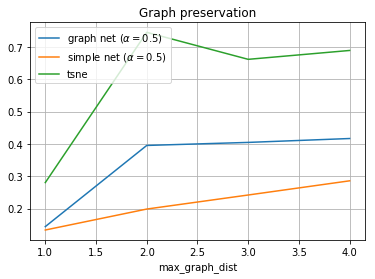

In [24]:
test_range = list(range(1, 5))
scores = np.zeros(len(test_range))

for label, embedding in embeddings_dict.items():
    for i, k in enumerate(test_range):
        scores[i] = neighborhood_preservation(path_matrix, embedding, max_graph_dist=k)
    plt.plot(test_range, scores, label=label)
        
plt.legend()
plt.xlabel('max_graph_dist')
plt.grid(True)
plt.title('Graph preservation')

Text(0.5,1,'Feature preservation')

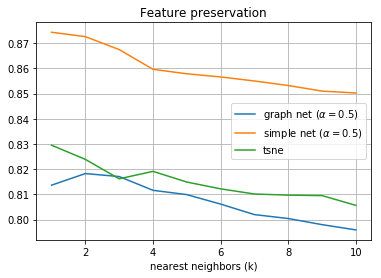

In [25]:
test_range = list(range(1, 11))
scores = np.zeros(len(test_range))

D = pairwise_distances(inputs, metric='cosine')

for label, embedding in embeddings_dict.items():
    for i, k in enumerate(test_range):
        scores[i] = trustworthiness(D, embedding, precomputed=True, n_neighbors=k)
    plt.plot(test_range, scores, label=label)
        
plt.legend()
plt.xlabel('nearest neighbors (k)')
plt.grid(True)
plt.title('Feature preservation')